# Final Project for Applied Data Science (T-786-APDS)


Aró Berg Jónasar

aro24@ru.is


Áslaug Vanessa Ólafsdóttir

aslaug20@ru.is


May 18th, 2025

To assist those looking marketing agencies and industry professionals aiming to optimize promotional strategies, we aim to predict the popularity of songs based on various features. Popularity is typically measured in streaming count, user ratings, and general engagement. By applying a machine learning model to a large music dataset, we hope to better understand what attributes of a song influence popularity.

Our research questions are:

*   RQ1: What features have a significant impact on predicting song popularity?
*   RQ2: How accurately can a regression model predict song popularity?

The criteria for success are that the model performs better than a baseline model that predicts popularity by averaging the popularity score within a genre.

The dataset is from Kaggle and is called “Spotify_1Million_Tracks”. It contains metadata of one million songs from Spotify from the years 2000 to 2023.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import shap
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import tree

In [3]:
df = pd.read_csv('data/spotify_data.csv', index_col=0)

# Data Exploration

In [4]:
df.head()

,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,240166,3
1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,216387,4
2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,158960,4
3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,304293,4
4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,244320,4


In [5]:
df.describe(include='number')

,popularity,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06,1.159764e+06
mean,1.838312e+01,2.011955e+03,5.374382e-01,6.396699e-01,5.287778e+00,-8.981353e+00,6.346533e-01,9.281477e-02,3.215370e-01,2.523489e-01,2.230189e-01,4.555636e-01,1.213771e+02,2.495618e+05,3.885879e+00
std,1.588554e+01,6.803901e+00,1.844780e-01,2.705009e-01,3.555197e+00,5.682215e+00,4.815275e-01,1.268409e-01,3.549872e-01,3.650731e-01,2.010707e-01,2.685190e-01,2.977975e+01,1.494262e+05,4.676967e-01
min,0.000000e+00,2.000000e+03,0.000000e+00,0.000000e+00,0.000000e+00,-5.810000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.073000e+03,0.000000e+00
25%,5.000000e+00,2.006000e+03,4.130000e-01,4.540000e-01,2.000000e+00,-1.082900e+01,0.000000e+00,3.710000e-02,6.400000e-03,1.050000e-06,9.790000e-02,2.260000e-01,9.879700e+01,1.810910e+05,4.000000e+00
50%,1.500000e+01,2.012000e+03,5.500000e-01,6.940000e-01,5.000000e+00,-7.450000e+00,1.000000e+00,5.070000e-02,1.470000e-01,1.760000e-03,1.340000e-01,4.380000e-01,1.219310e+02,2.257440e+05,4.000000e+00
75%,2.900000e+01,2.018000e+03,6.770000e-01,8.730000e-01,8.000000e+00,-5.276000e+00,1.000000e+00,8.900000e-02,6.400000e-01,6.140000e-01,2.920000e-01,6.740000e-01,1.399030e+02,2.869135e+05,4.000000e+00
max,1.000000e+02,2.023000e+03,9.930000e-01,1.000000e+00,1.100000e+01,6.172000e+00,1.000000e+00,9.710000e-01,9.960000e-01,1.000000e+00,1.000000e+00,1.000000e+00,2.499930e+02,6.000495e+06,5.000000e+00


In [6]:
df.describe(include='object')

,artist_name,track_name,track_id,genre
count,1159749,1159763,1159764,1159764
unique,64158,882360,1159764,82
top,Traditional,Intro,4oMiOwhDZEdBuzAfhzRHbi,black-metal
freq,4058,466,1,21852


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1159764 entries, 0 to 1473395
Data columns (total 19 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   artist_name       1159749 non-null  object 
 1   track_name        1159763 non-null  object 
 2   track_id          1159764 non-null  object 
 3   popularity        1159764 non-null  int64  
 4   year              1159764 non-null  int64  
 5   genre             1159764 non-null  object 
 6   danceability      1159764 non-null  float64
 7   energy            1159764 non-null  float64
 8   key               1159764 non-null  int64  
 9   loudness          1159764 non-null  float64
 10  mode              1159764 non-null  int64  
 11  speechiness       1159764 non-null  float64
 12  acousticness      1159764 non-null  float64
 13  instrumentalness  1159764 non-null  float64
 14  liveness          1159764 non-null  float64
 15  valence           1159764 non-null  float64
 16  tempo

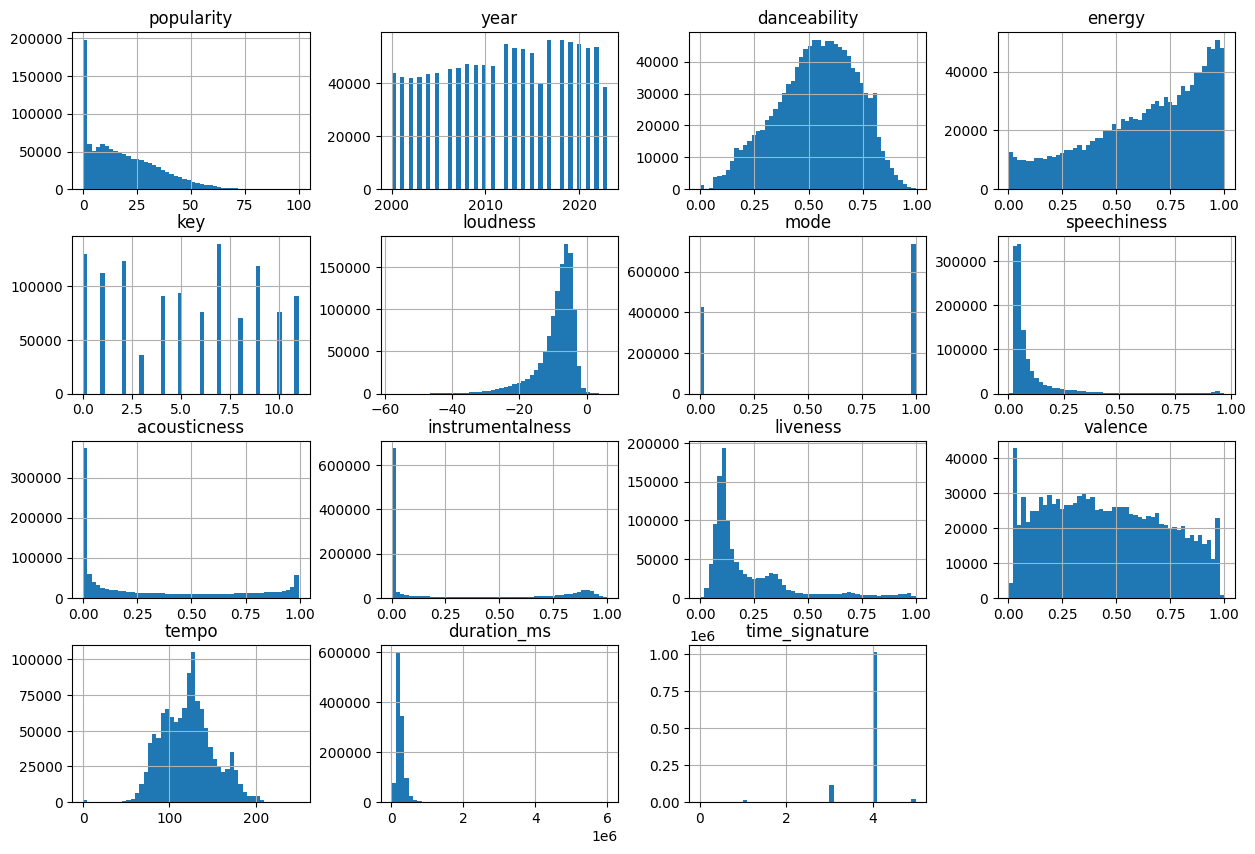

In [8]:
df.hist(figsize=(15, 10), bins=50)
plt.show()

How much of the data has popularity score of 0?

In [9]:
perc = (df['popularity'] == 0).mean() * 100
print(perc)

13.6571750804474


Find the top 10 genres and plot the average popularity over the years.

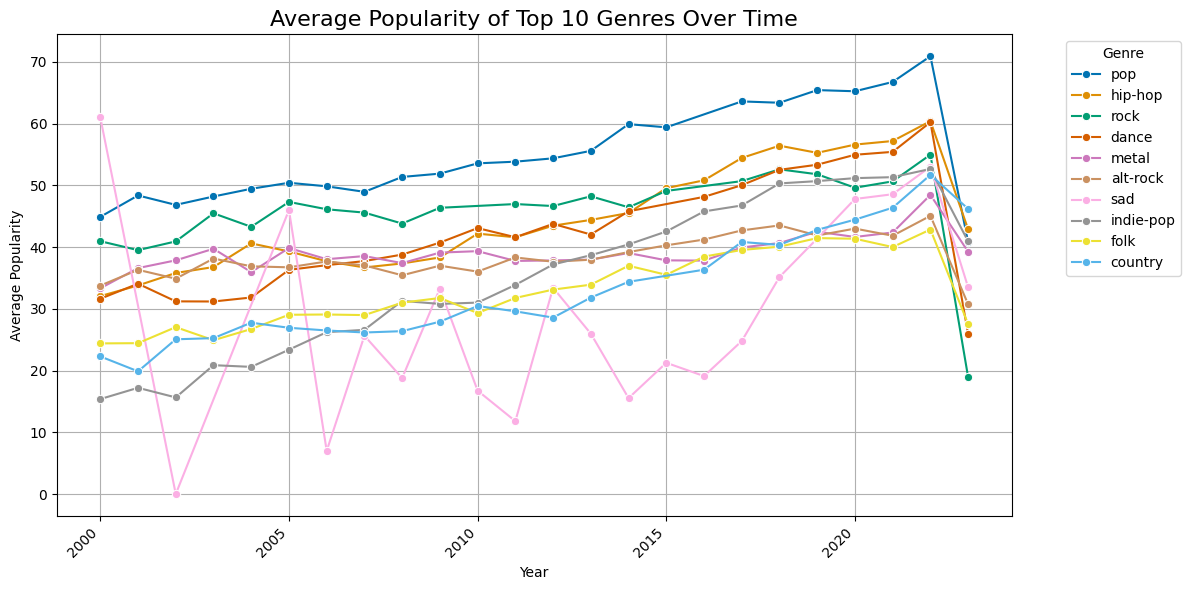

In [10]:
top_genres = df.groupby('genre')['popularity'].mean().reset_index()
top_genres_sorted = top_genres.sort_values(by='popularity', ascending=False)
top10_genres = top_genres_sorted.head(10)

genre_year_avg = df.groupby(['genre', 'year'])['popularity'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=genre_year_avg, x='year', y='popularity', hue='genre', palette='colorblind', hue_order=top10_genres['genre'], marker='o')
plt.title('Average Popularity of Top 10 Genres Over Time', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Average Popularity')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Find the sum of popularity over the years for each genre.

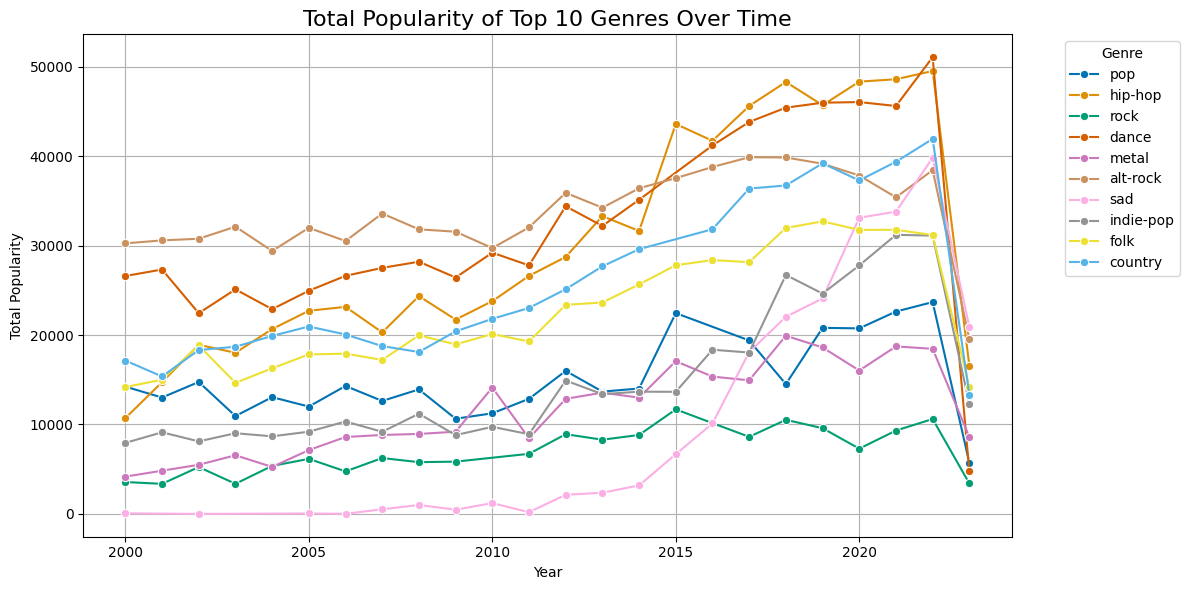

In [11]:
genre_year_total = df.groupby(['genre', 'year'])['popularity'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=genre_year_total, x='year', y='popularity', hue='genre', hue_order=top10_genres['genre'], palette='colorblind', marker='o')

plt.title('Total Popularity of Top 10 Genres Over Time', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Total Popularity')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


Does the number of songs reflect the popularity of each genre?

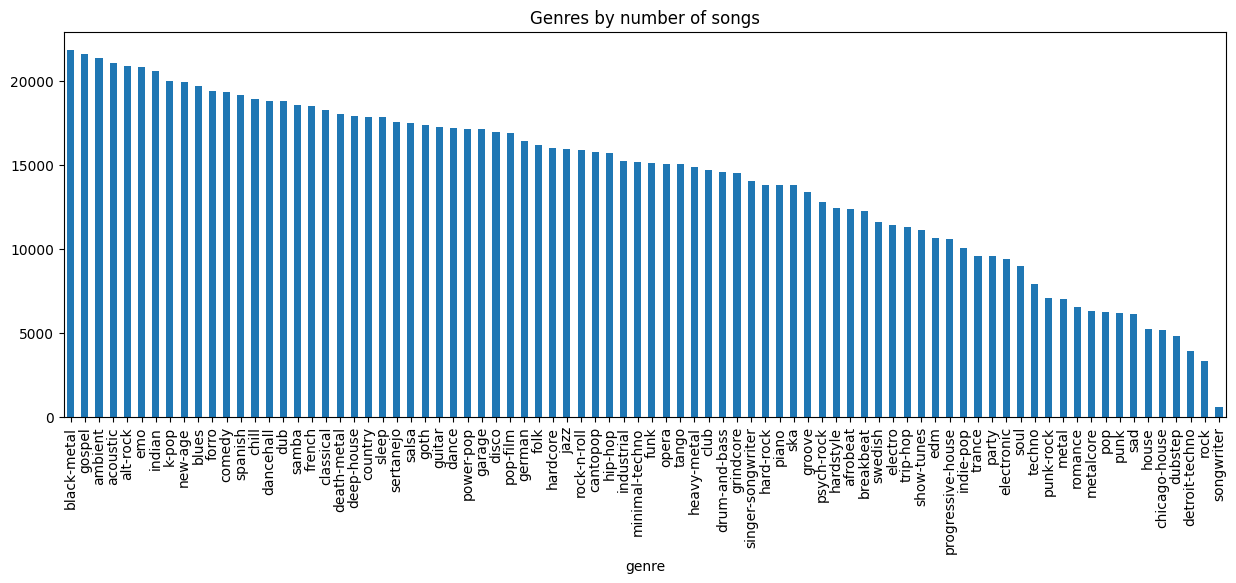

In [12]:
values = df['genre'].value_counts()
values.plot(kind='bar', figsize=(15, 5), title='Genres by number of songs')
plt.show()

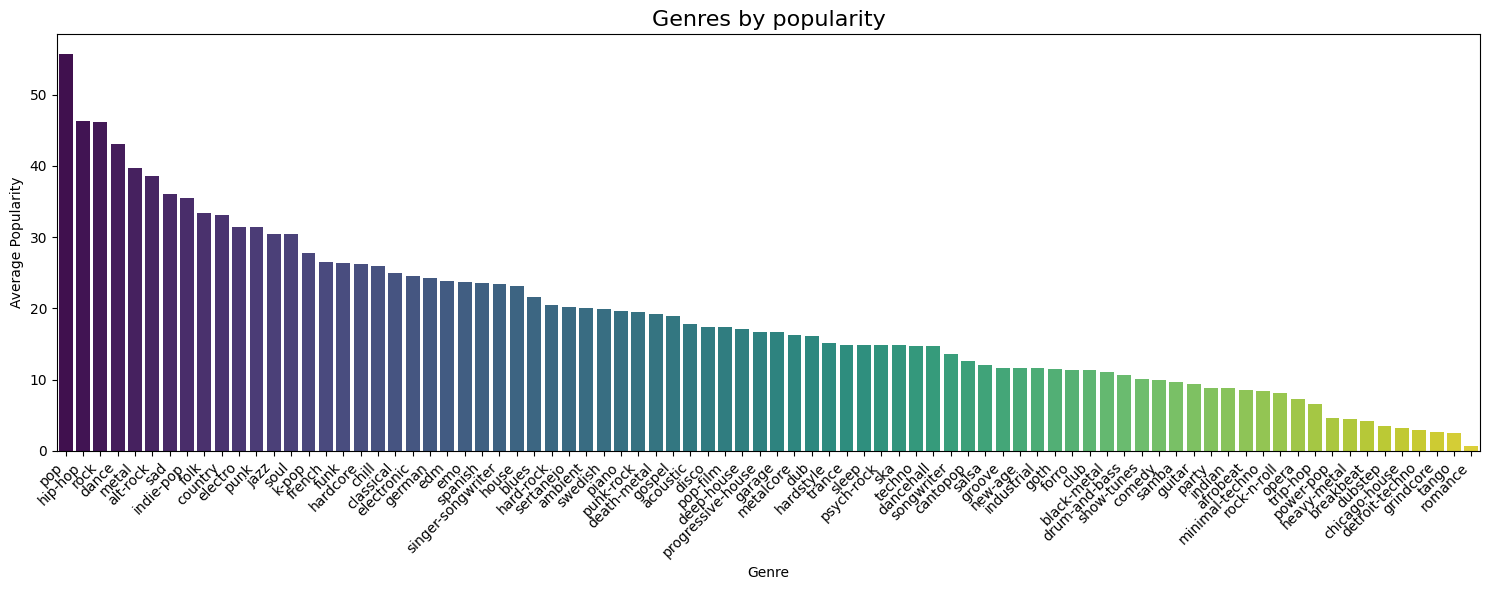

In [13]:
plt.figure(figsize=(15, 6))
sns.barplot(data=top_genres_sorted, x='genre', y='popularity', hue='genre', palette='viridis')

plt.title('Genres by popularity', fontsize=16)
plt.xlabel('Genre')
plt.ylabel('Average Popularity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

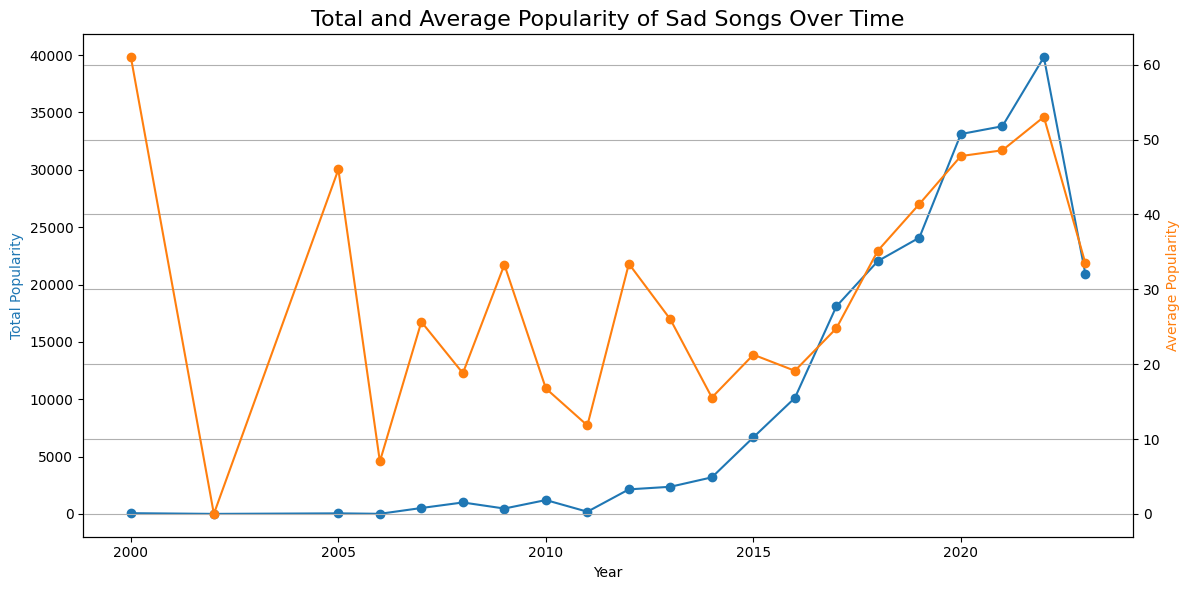

In [14]:
sad_df = df[df['genre'] == 'sad']
sad_df_grouped = sad_df.groupby('year')['popularity'].sum().reset_index()
sad_df_avg_grouped = sad_df.groupby('year')['popularity'].mean().reset_index()

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Popularity', color='tab:blue')
ax1.plot(sad_df_grouped['year'], sad_df_grouped['popularity'], color='tab:blue', marker='o')

ax2 = ax1.twinx()
ax2.set_ylabel('Average Popularity', color='tab:orange')
ax2.plot(sad_df_avg_grouped['year'], sad_df_avg_grouped['popularity'], color='tab:orange', marker='o')

plt.title('Total and Average Popularity of Sad Songs Over Time', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

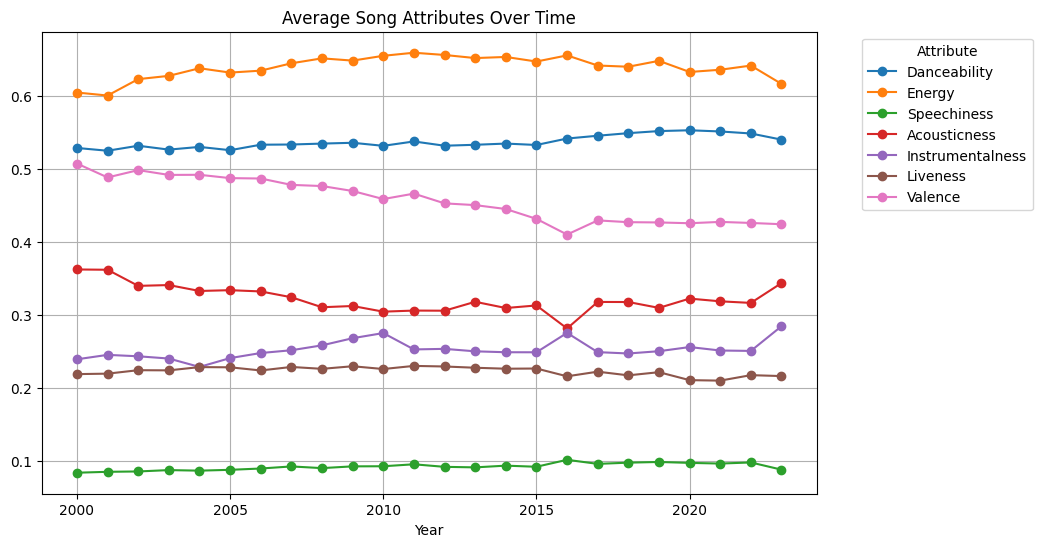

In [15]:
average_danceability_by_year = df.groupby('year')['danceability'].mean()
average_energy_by_year = df.groupby('year')['energy'].mean()
average_speechiness_by_year = df.groupby('year')['speechiness'].mean()
average_acousticness_by_year = df.groupby('year')['acousticness'].mean()
average_instrumentalness_by_year = df.groupby('year')['instrumentalness'].mean()
average_liveness_by_year = df.groupby('year')['liveness'].mean()
average_valence_by_year = df.groupby('year')['valence'].mean()

plt.figure(figsize=(10, 6))
plt.plot(average_danceability_by_year.index, average_danceability_by_year.values, marker='o', label='Danceability')
plt.plot(average_energy_by_year.index, average_energy_by_year.values, marker='o', label='Energy')
plt.plot(average_speechiness_by_year.index, average_speechiness_by_year.values, marker='o', label='Speechiness')
plt.plot(average_acousticness_by_year.index, average_acousticness_by_year.values, marker='o', label='Acousticness')
plt.plot(average_instrumentalness_by_year.index, average_instrumentalness_by_year.values, marker='o', label='Instrumentalness')
plt.plot(average_liveness_by_year.index, average_liveness_by_year.values, marker='o', label='Liveness')
plt.plot(average_valence_by_year.index, average_valence_by_year.values, marker='o', label='Valence')

plt.xlabel('Year')
plt.title('Average Song Attributes Over Time')
plt.legend(title='Attribute', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

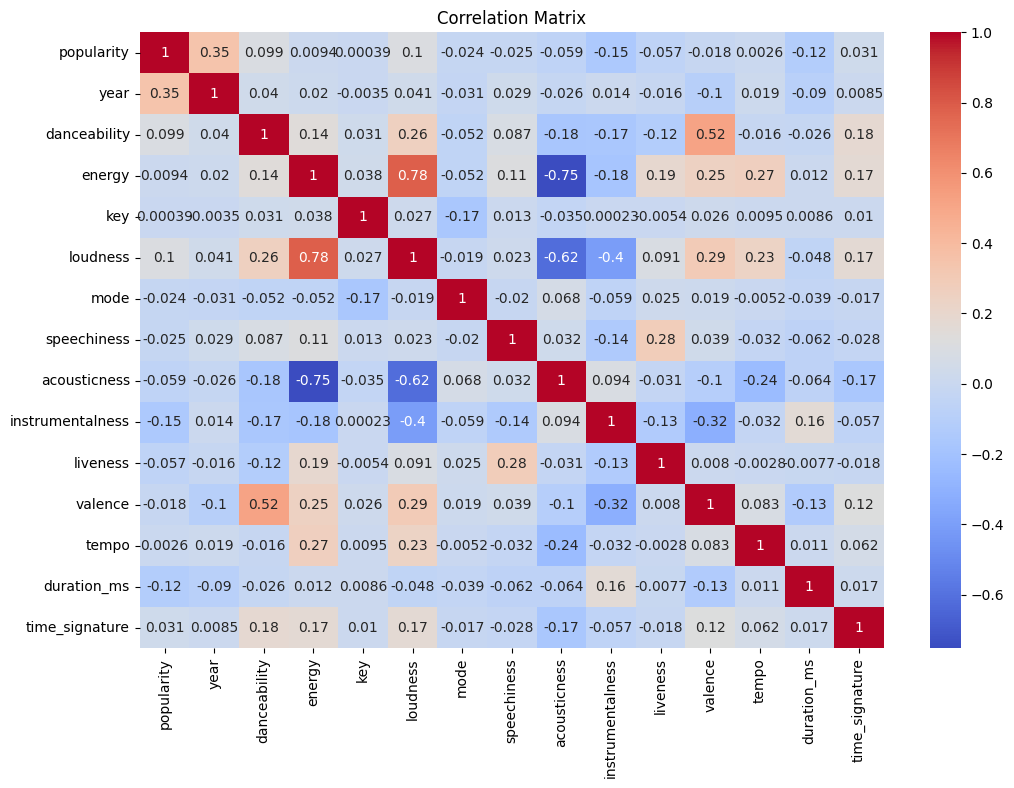

In [16]:
number_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(12, 8))
sns.heatmap(number_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Scatter plot of popularity as a function of the other numeric variables.

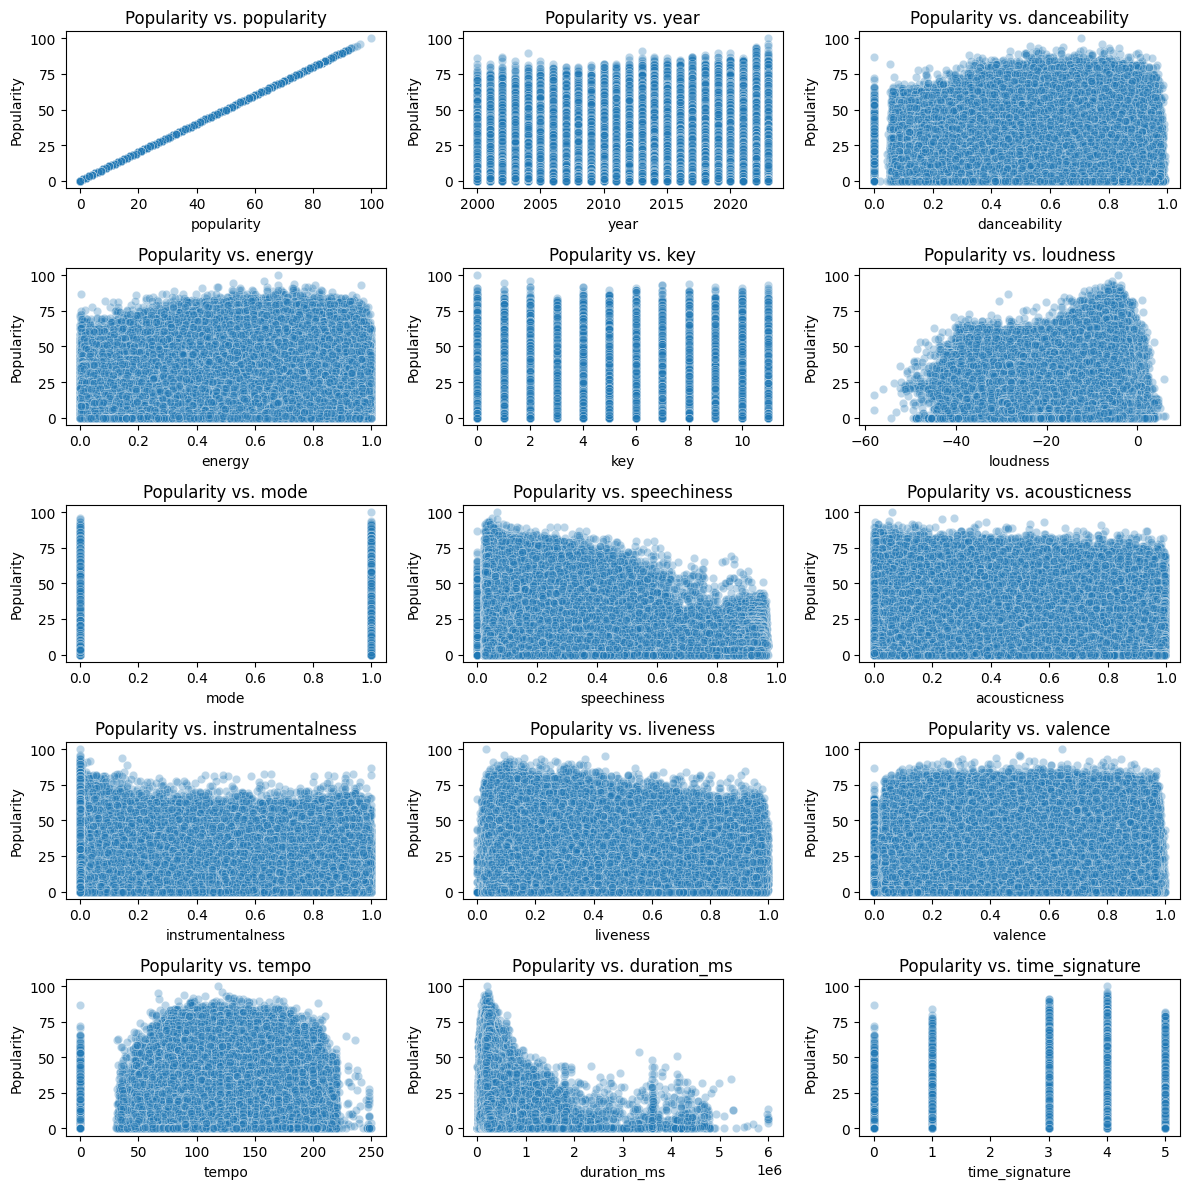

In [17]:
n_cols = 3
n_rows = -(-len(number_df.columns) // n_cols)

plt.figure(figsize=(12, 12))

for i, col in enumerate(number_df, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.scatterplot(data=df, x=col, y='popularity', alpha=0.3)
    plt.title(f'Popularity vs. {col}')
    plt.xlabel(col)
    plt.ylabel('Popularity')

plt.tight_layout()
plt.show()

# Preprocessing

Identify missing values

In [18]:
df.isna().sum()

artist_name         15
track_name           1
track_id             0
popularity           0
year                 0
genre                0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
duration_ms          0
time_signature       0
dtype: int64

There seems to be no missing data apart from a few artist name and track name, which will be deleted.

Check duplicates where track name and artist name is the same.

In [19]:
duplicate_rows = df[df.duplicated(subset=['track_name', 'artist_name'])]
print(f"Total duplicate rows: {duplicate_rows.shape[0]}")

Total duplicate rows: 0


There are no duplicates.

Remove columns we don't need for our model, and check how it looks after cleaning.

In [20]:
df = df.drop(columns=['artist_name', 'track_name', 'track_id'])
df.head()

,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,240166,3
1,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,216387,4
2,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,158960,4
3,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,304293,4
4,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,244320,4


Split the data into training and testing sets.

In [21]:
random_seed = 1705

train_set, test_set = train_test_split(df, test_size=0.2, random_state=random_seed)

Create one dataframe for the labels, 'y', and one for the other features

In [22]:
X = train_set.drop(columns=['popularity'])
y = train_set['popularity'].copy()

Standardize numerical values and One hot encode objects.

In [23]:
num_attributes = list(X.select_dtypes(include=['number']))
cat_attributes = list(X.select_dtypes(exclude=['number']))

pipeline = ColumnTransformer([
    ('num', StandardScaler(), num_attributes),
    ('cat', OneHotEncoder(), cat_attributes)
])

X_prepared = pipeline.fit_transform(X)

# The Model

### Baseline Model

The criteria for success are that the model performs better than a baseline model that predicts popularity by averaging the popularity score within a genre.

In [24]:
baseline_model = train_set.groupby('genre')['popularity'].mean().to_dict()
baseline_model_preds = train_set['genre'].map(baseline_model)

### Random Forest Regression Model

Use GridSearch to find the best hyperparameters.

In [25]:
sample_size = 1000
X_prepared_sample = X_prepared[:sample_size]
y_sample = y[:sample_size]

param_grid = {
    'max_depth': [5,10,20],
    'max_features' : [5,10,20],
    'n_estimators': [20,50]}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=random_seed),
param_grid=param_grid,cv=KFold(n_splits=5, shuffle=True, random_state=random_seed))
grid_search.fit(X_prepared_sample, y_sample)
print(grid_search.best_params_)

{'max_depth': 20, 'max_features': 10, 'n_estimators': 50}


Use the best parameters from the grid search to create a Random Forest Regression model.

In [26]:
n_est = grid_search.best_params_['n_estimators']
max_depth = grid_search.best_params_['max_depth']
max_features = grid_search.best_params_['max_features']
regressor_model = RandomForestRegressor(n_estimators=n_est, max_depth=max_depth, max_features=max_features, random_state=random_seed)
regressor_model.fit(X_prepared, y)
reg_preds = regressor_model.predict(X_prepared)

### Model Evaluation (training data)

#### Baseline Model Evaluation

In [27]:
print(f"Mean absolute error: {mean_absolute_error(train_set['popularity'], baseline_model_preds)}")
print(f"Baseline RMSE: {np.sqrt(mean_squared_error(train_set['popularity'], baseline_model_preds))}")
print(f"Baseline R^2: {r2_score(train_set['popularity'], baseline_model_preds)}")

Mean absolute error: 9.535535629401041
Baseline RMSE: 12.181863338807071
Baseline R^2: 0.4125397955205584


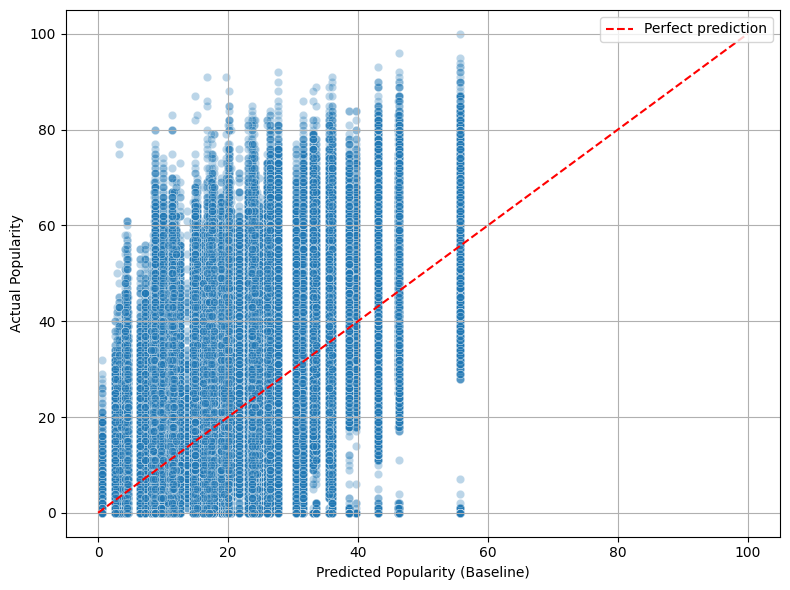

In [28]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=baseline_model_preds, y=train_set['popularity'], alpha=0.3)
plt.xlabel("Predicted Popularity (Baseline)")
plt.ylabel("Actual Popularity")
plt.plot([0, 100], [0, 100], 'r--', label="Perfect prediction")
plt.grid(True)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

#### Regression Model Evaluation

In [29]:
print(f"Mean absolute error: {mean_absolute_error(y, reg_preds)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y, reg_preds))}")
print(f"R^2: {r2_score(y, reg_preds)}")

Mean absolute error: 8.435227324125393
RMSE: 10.678691717550059
R^2: 0.5485734435813987


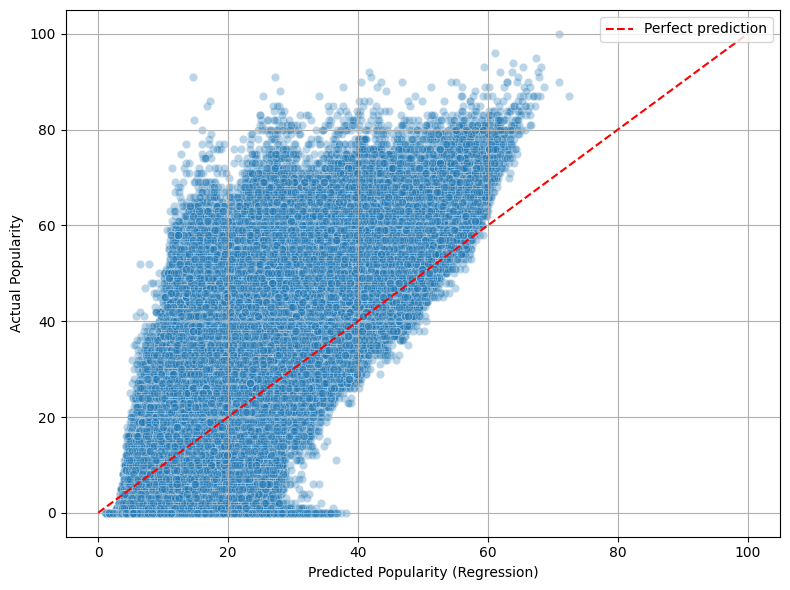

In [30]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reg_preds, y=y, alpha=0.3)
plt.plot([0, 100], [0, 100], 'r--', label="Perfect prediction")
plt.xlabel("Predicted Popularity (Regression)")
plt.ylabel("Actual Popularity")
plt.grid(True)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

Plot the residuals from the Random Forest model

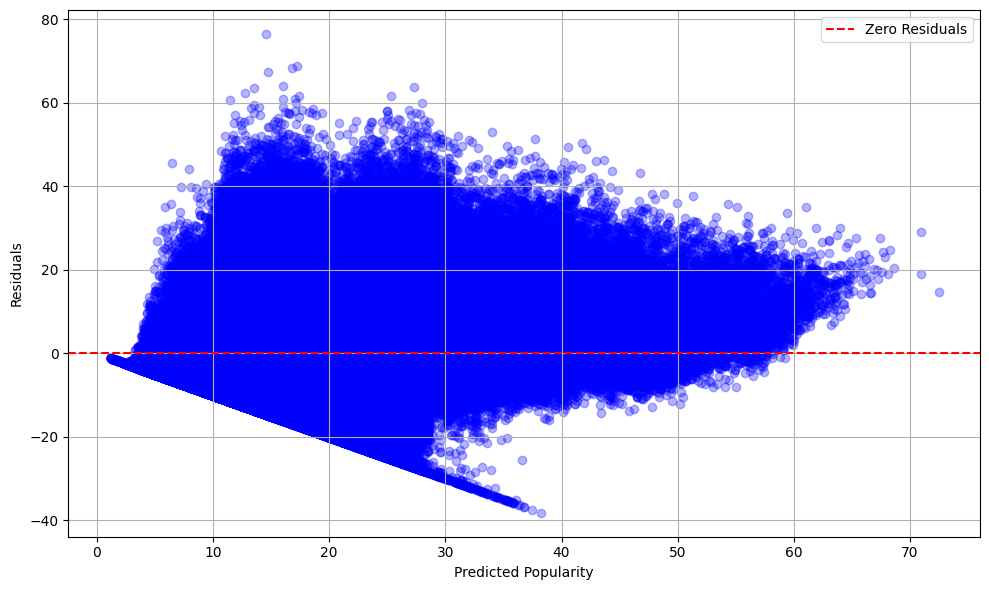

In [31]:
residuals = y - reg_preds
plt.figure(figsize=(10, 6))
plt.scatter(x=reg_preds, y=residuals, alpha=0.3, color='blue')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Residuals')
plt.xlabel('Predicted Popularity')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Comparison of the Baseline Model and Regression Model

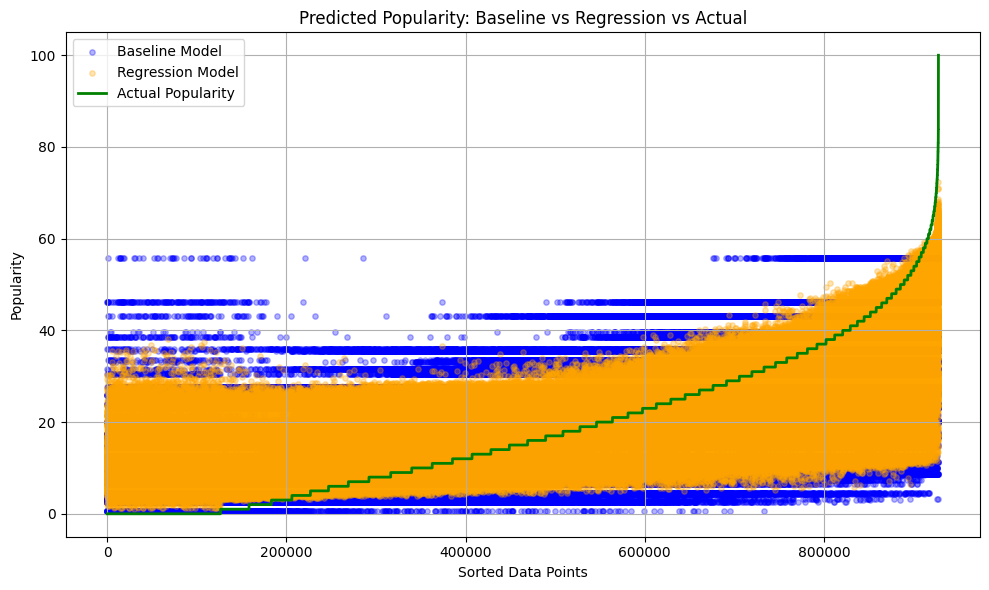

In [32]:
sorted_idx = train_set['popularity'].sort_values().index
reg_preds = pd.Series(reg_preds, index=train_set.index)

plt.figure(figsize=(10, 6))
plt.scatter(x=range(len(sorted_idx)), y=baseline_model_preds.loc[sorted_idx], label='Baseline Model', color='blue', alpha=0.3, s=15)
plt.scatter(x=range(len(sorted_idx)), y=reg_preds.loc[sorted_idx], label='Regression Model', color='orange', alpha=0.3, s=15)
plt.plot(range(len(sorted_idx)), train_set['popularity'].loc[sorted_idx], label='Actual Popularity', color='green', linewidth=2)

plt.xlabel('Sorted Data Points')
plt.ylabel('Popularity')
plt.title('Predicted Popularity: Baseline vs Regression vs Actual')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Model Interpretation

Start with checking what features are the most important in the model.

In [33]:
def get_feature_names_from_column_transformer(ct):
    output_features = []

    for name, transformer, columns in ct.transformers_:
        if name == 'remainder' and transformer == 'drop':
            continue

        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(columns)
        else:
            names = columns  # fallback for passthrough or scaler
        output_features.extend(names)

    return output_features

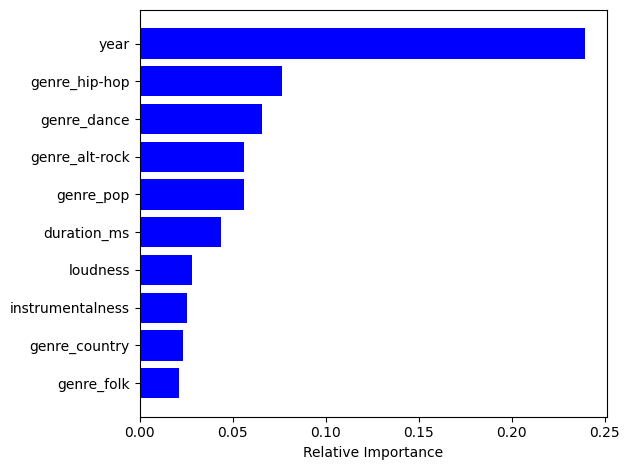

In [34]:
importances = regressor_model.feature_importances_
indices = np.argsort(importances)
num_features = 10
feature_names = get_feature_names_from_column_transformer(pipeline)
std = np.std([tree.feature_importances_ for tree in regressor_model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
plt.barh(range(num_features), importances[indices[-num_features:]], color='b', align='center')
plt.yticks(range(num_features), [feature_names[i] for i in indices[-num_features:]])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

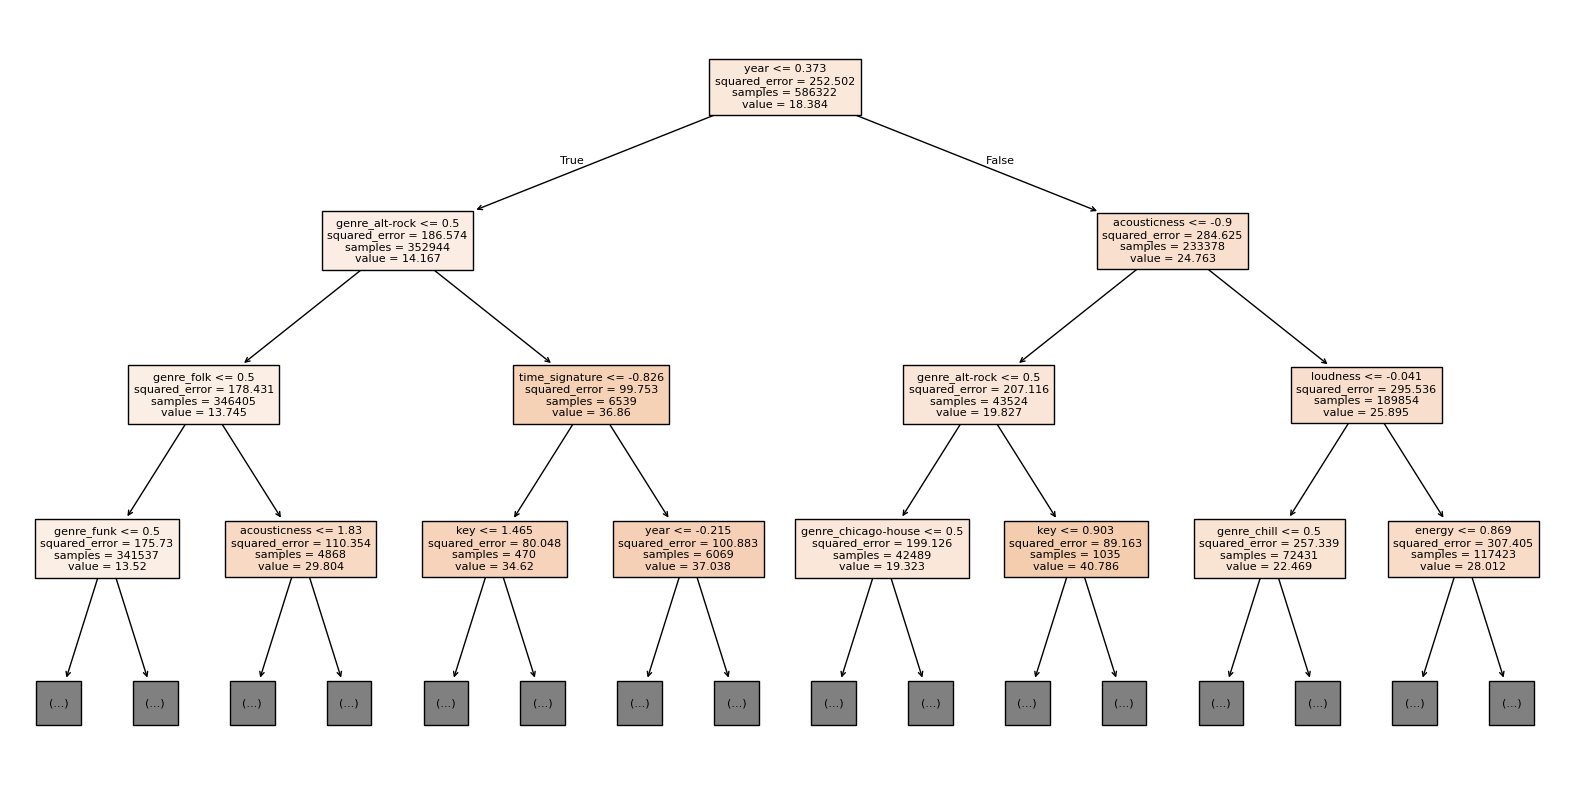

In [35]:
plt.figure(figsize=(20, 10))
tree.plot_tree(regressor_model.estimators_[1],
               max_depth=3,
               filled=True,
               feature_names=feature_names,
               fontsize=8)
plt.show()

#### SHAP plots

In [47]:
X_shap_sample = X_prepared[:50]
X_dense = X_shap_sample.toarray()

explainer = shap.TreeExplainer(regressor_model)
shap_values = explainer(X_dense, check_additivity=False)

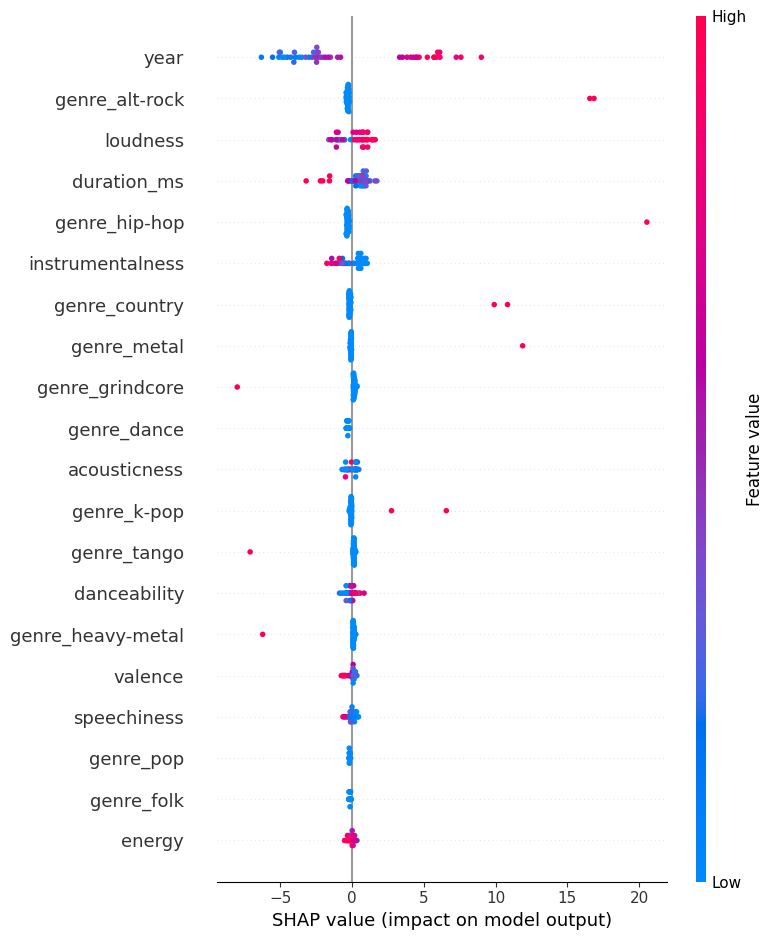

In [48]:
shap.summary_plot(shap_values, X_dense, feature_names=feature_names)

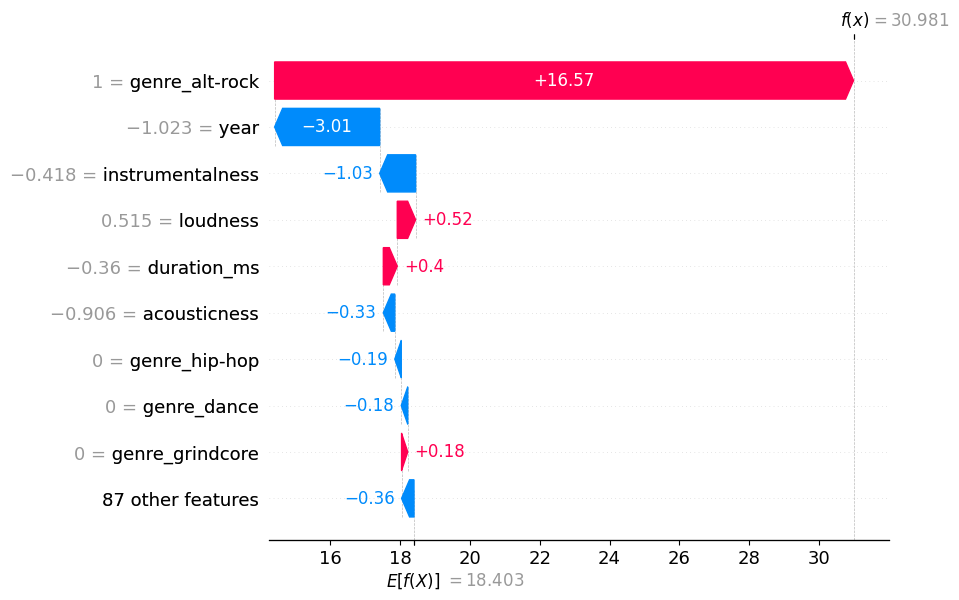

In [49]:
X_df = pd.DataFrame(X_dense, columns=feature_names)
shap_values = explainer(X_df)
shap.plots.waterfall(shap_values[0])

# Model Performance on testing data

In [45]:
X_test = test_set.drop(columns=['popularity'])
y_test = test_set['popularity'].copy()

X_test_prepared = pipeline.transform(X_test)
test_preds = regressor_model.predict(X_test_prepared)

print(f"Mean absolute error: {mean_absolute_error(y_test, test_preds)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, test_preds))}")
print(f"R^2: {r2_score(y_test, test_preds)}")

Mean absolute error: 8.693226777019614
RMSE: 10.996675929741407
R^2: 0.5188123572569041


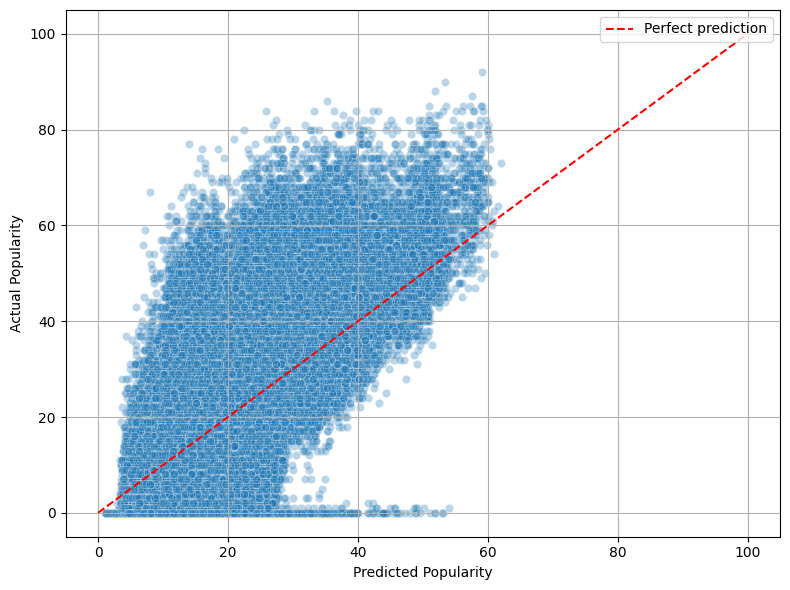

In [46]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=test_preds, y=y_test, alpha=0.3)
plt.plot([0, 100], [0, 100], 'r--', label="Perfect prediction")
plt.xlabel("Predicted Popularity")
plt.ylabel("Actual Popularity")
plt.grid(True)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()